<a href="https://colab.research.google.com/github/MeriemTerki/Optical-Character-Recognition/blob/main/OCR_Text_recognition_by_Tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Receipt OCR : Problem definition
Given a arbitrary photo containing a receipt, extract grand total

We will break down this problem into smaller tasks:
1. Get a scanned version of receipt by restoring perspective
2. Apply OCR to find all texts within image
3. Find grand total as the largest number among recognized texts

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
import pytesseract

import re

from pytesseract import Output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


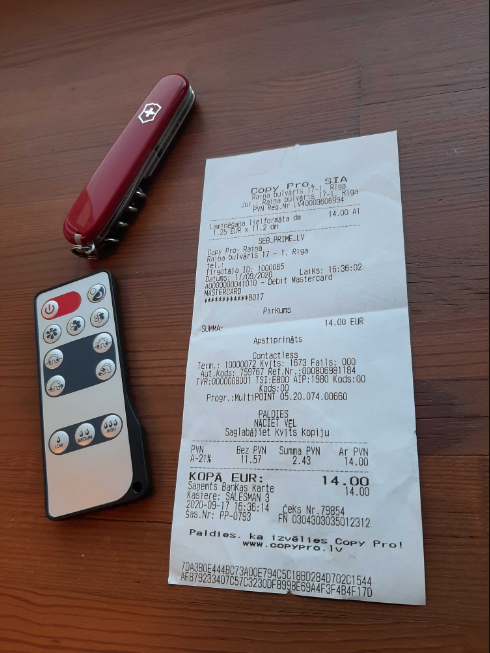

In [ ]:
# Sample file out of the dataset
file_name = '/content/drive/MyDrive/DeepLearningProjects/OCR/OCRImages/20201007_110604.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

## Step 1: Receipt Contour Detection
In order to find receipt contour, standart edge detection preprocessing is applied:

1. Convert image to grayscale
2. Aplly Gaussian filter 5x5 to get rid of noise
3. Run Canny edge detector

Let's define some utility methods:

In [ ]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [ ]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

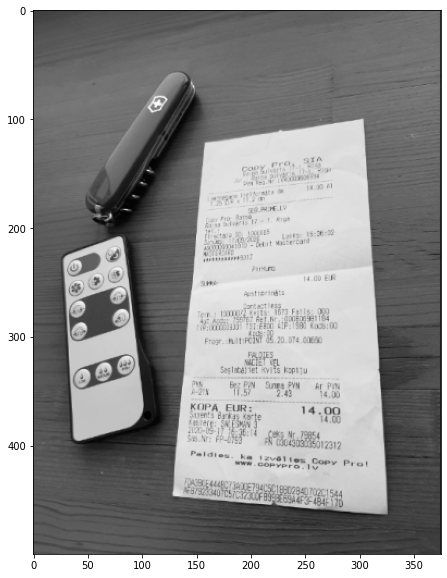

In [ ]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

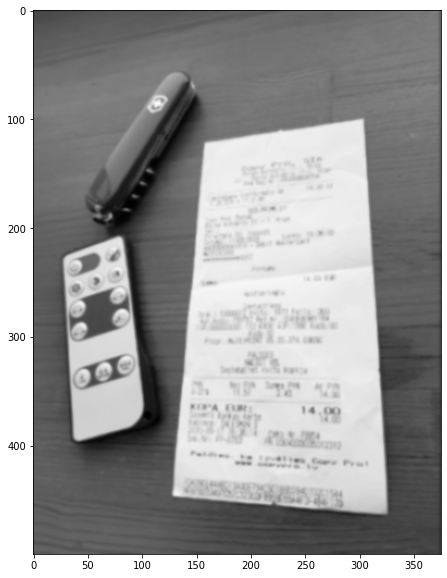

In [ ]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

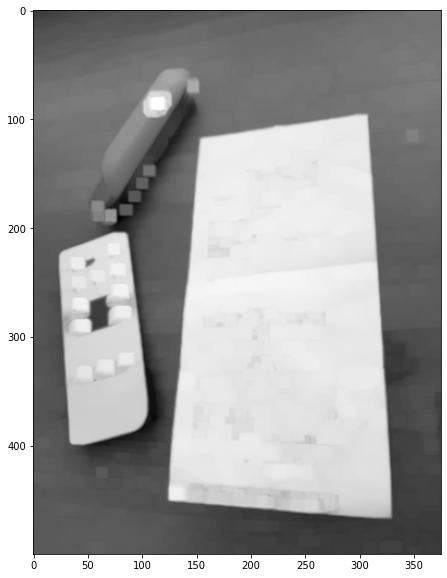

In [ ]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

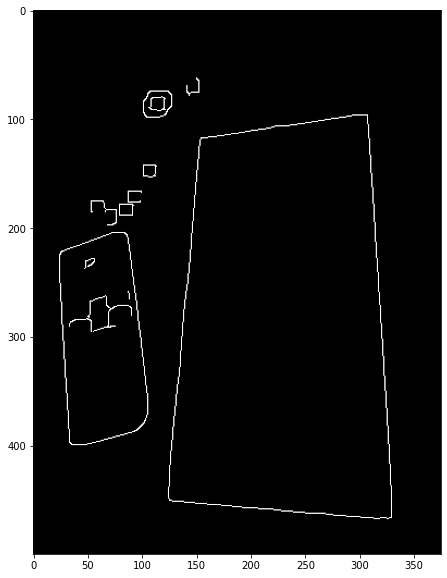

In [ ]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

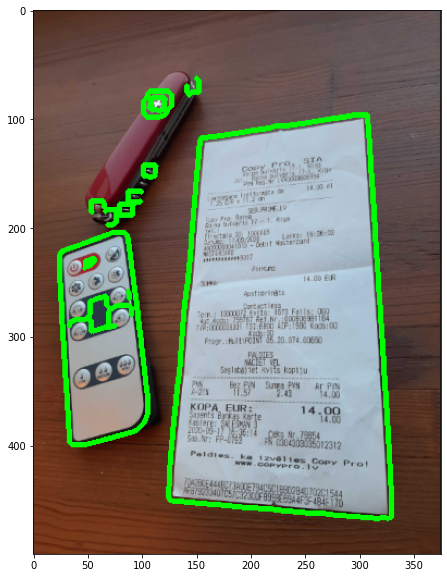

In [ ]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

#### To find the contour of receipt we will make use of two simple heuristics:

- receipt is the largest contour whithin image
- receipt is expected to be of a rectangular shape


We will start with the first heuristic by getting TOP largest contours.

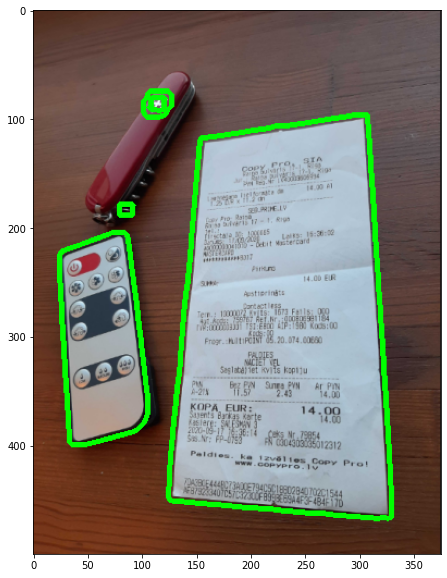

In [ ]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible. It takes perimeter as one of the arguments, so we have to calculate it with arcLength. Let's define a helper method that does the approximation:

In [ ]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

This allows us to find a rectangle by looking whether the number of approximated contour points is 4:

In [ ]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [ ]:
get_receipt_contour(largest_contours)

array([[[307,  96]],

       [[154, 117]],

       [[125, 450]],

       [[329, 466]]], dtype=int32)

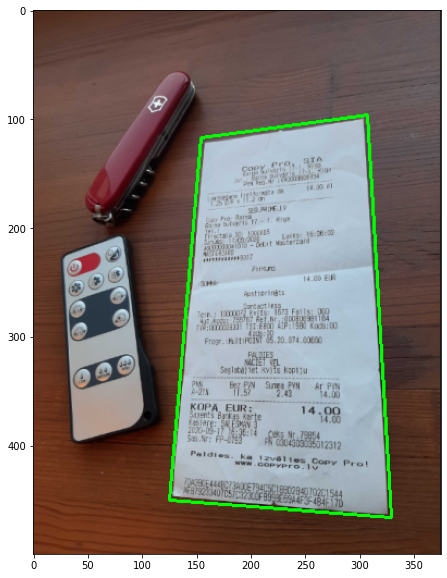

In [ ]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

## Step 2: Cropping and perspective restoration
We will make use of cv2.warpPerspective to restore perspective of the receipt. We have to do some preparations though:

1. convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
2. use rectangle points to calculate destination points of the "scanned" view
3. feed destination points into cv2.getPerspectiveTransform to calculate transformation matrix
4. and finally use cv2.warpPerspective to restore the perspective!

In [ ]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [ ]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

Now we can make use of helper methods defined to get a perspective version of the receipt:

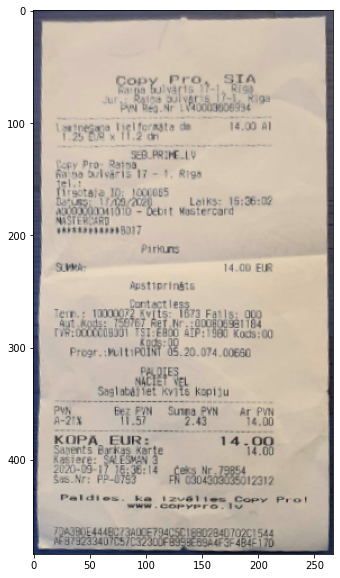

In [ ]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

Now the final part - obtain black and white scanner effect with the color transformation:

In [ ]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

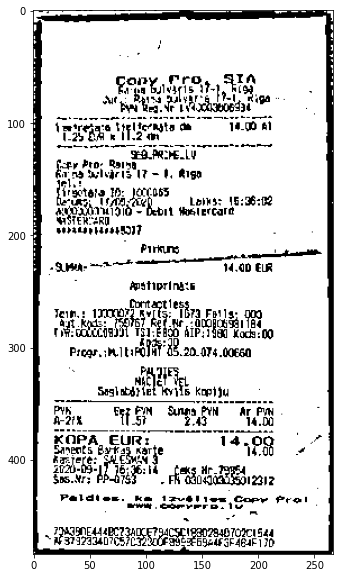

In [ ]:
result = bw_scanner(scanned)
plot_gray(result)

In [ ]:
output = Image.fromarray(result)
output.save('result.png')

We will use a scanned version of the receipt, which is the output

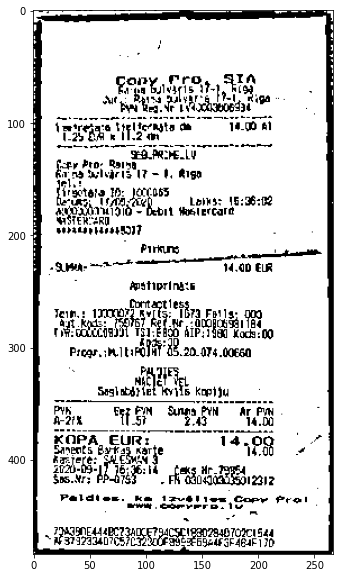

In [ ]:
file_name = "/content/result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

## Step 3: Text box detection

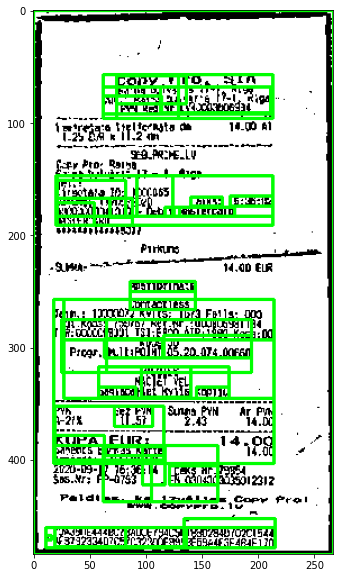

In [ ]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

## Step 4: Text recognition

In [ ]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

Feekasy fe
opel eagle

Game oe vas yak
Foe oie

nt sastaneare

fesrins

LTR
ie mite ane
sie EA one

ae
Koga ug

ce SY pene

~ PSD ce emma

 



## Step 4: Extracting grand total

In [ ]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [ ]:
amounts = find_amounts(extracted_text)
amounts

[]

Grand total is the largest one:

In [ ]:
max(amounts)